# MAGPRIME Tutorial notebook
This notebook provides a tutorial for using the MAGPRIME Python library to clean and process magnetometer data. MAGPRIME implements several algorithms for removing noise and interference from magnetometer measurements.

In this tutorial, we will cover:

* Loading sample magnetometer data from the QSZ-1 Japanese GNSS Satellite.
* Visualizing and assessing the raw data
* Preprocessing steps like detrending, filtering, etc.
* Applying MAGPRIME's noise removal algorithms:
    * Independent Component Analysis (ICA)
    * Multivariate Singular Spectrum Analysis (MSSA)
    * Gradiometry 
    * Principal Component Gradiometry
    * SHEINKER
    * Frequency-Based Gradiometry
    * Underdetermined Blind Source Separation (UBSS)
    * Wavelet-Adaptive Interference Cancellation for Underdetermined Platforms (WAIC-UP)
* Comparing noise removal performance

Let's get started!

### Load data from Michibiki-1 Magnetometers
In this tutorial, we will use noisy magnetometer data from the [Michibiki-1 satellite](https://sees.tksc.jaxa.jp/fw/dfw/SEES/English/Papers/data/2020/peer_reviewed/01/2020_reviewed_01.shtml). This data is featured in Imajo et al. (2021) to showcase the use of ICA to clean magnetometer data. 

This code loads the raw biased Michibiki-1 magnetometer data from a .dat file into a matrix called B_qzs. The known bias values are subtracted from each sensor axis.

Since some algorithms like UBSS and MSSA are computationally intensive, the data is decimated to 0.1 Hz to speed up processing.

c:\Users\aphoffm2\AppData\Local\anaconda3\Lib\site-packages\pymssa\mssa.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


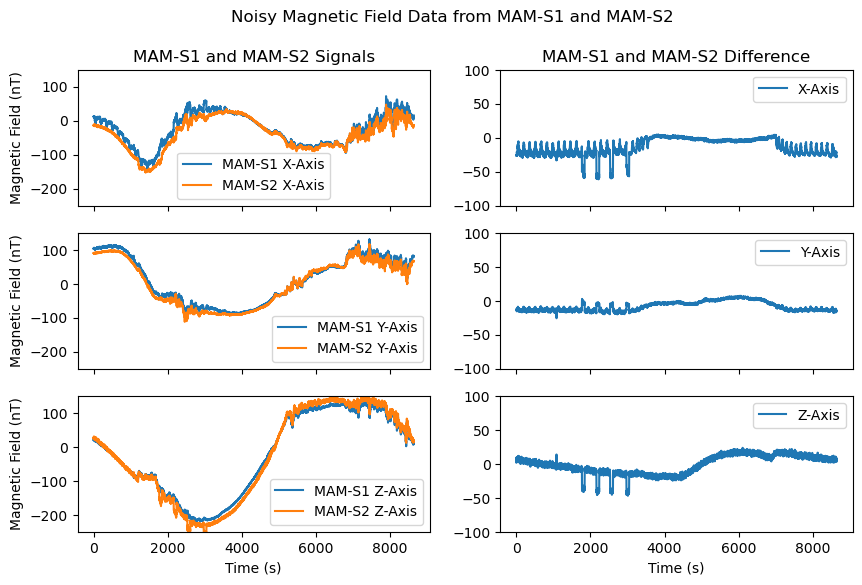

In [1]:
"Import the necessary modules"
from magprime import utility
import numpy as np
import matplotlib.pyplot as plt

"Load raw data with offsets"
B = utility.load_michibiki_data() # shape = (n_sensor, n_axis, n_samples)

"Decimate the data to 0.1 Hz because UBSS and MSSA are slow methods and it will take a long time to run on 86,400 data points"
B = B[:,:,::10]

"Create a 3 x 2-panel plot of MAM-S1 and MAM-S2 data with overlapping magnetometers in the same panel"
fig, axs = plt.subplots(3, 2, figsize=(10, 6), sharex=True)
fig.suptitle("Noisy Magnetic Field Data from MAM-S1 and MAM-S2")
axs[0,0].set_title("MAM-S1 and MAM-S2 Signals")
axs[0,0].plot(B[0,0], label="MAM-S1 X-Axis")
axs[0,0].plot(B[1,0], label="MAM-S2 X-Axis")
axs[0,0].set_ylabel("Magnetic Field (nT)")
axs[0,0].set_ylim(-250, 150)
axs[0,0].legend()

axs[1,0].plot(B[0,1], label="MAM-S1 Y-Axis")
axs[1,0].plot(B[1,1], label="MAM-S2 Y-Axis")
axs[1,0].set_ylabel("Magnetic Field (nT)")
axs[1,0].set_ylim(-250, 150)
axs[1,0].legend()

axs[2,0].plot(B[0,2], label="MAM-S1 Z-Axis")
axs[2,0].plot(B[1,2], label="MAM-S2 Z-Axis")
axs[2,0].set_xlabel("Time (s)")
axs[2,0].set_ylabel("Magnetic Field (nT)")
axs[2,0].set_ylim(-250, 150)
axs[2,0].legend()

axs[0,1].set_title("MAM-S1 and MAM-S2 Difference")
axs[0,1].plot(B[1,0]-B[0,0], label="X-Axis")
axs[0,1].legend()
axs[0,1].set_ylim(-100, 100)

axs[1,1].plot(B[1,1]-B[0,1], label="Y-Axis")
axs[1,1].legend()
axs[1,1].set_ylim(-100, 100)

axs[2,1].plot(B[1,2]-B[0,2], label="Z-Axis")
axs[2,1].set_ylim(-100, 100)
axs[2,1].set_xlabel("Time (s)")
axs[2,1].legend()

plt.show()

### Independent Component Analysis
Independent Component Analysis (ICA) is a blind source separation method that leverages the statistical independence of signals to separate the true geomagnetic field from noise sources in magnetometer data. It first detrends and preprocesses the data. The ICA algorithm then decomposes the data into independent components. To identify the natural magnetic field, it selects the ICs that have the lowest correlation with the difference between sensors, under the assumption ambient fields produce consistent signals. These ICs are used to reconstruct the denoised data. 

A summary of each algorithm and its parameters can be seen through calling

`help(algorithm)`

In [2]:
from magprime.algorithms import ICA
help(ICA)

Help on module magprime.algorithms.ICA in magprime.algorithms:

NAME
    magprime.algorithms.ICA

DESCRIPTION
    Author: Shun Imajo, Alex Hoffmann
    Last Update: 9/19/2023
    Description: This file implements a noise removal method using independent component
                 analysis (ICA) for magnetic field data from multiple magnetometers.
                 The method follows the approach of Imajo et al. (2021). The method
                 separates the noise components from the signal components based on
                 their statistical independence and non-Gaussianity. The natural magnetic
                 field components are then identified by their similarity in the mixing
                 matrix (ica.mixing_).

    General Parameters
    ----------
    uf : window size for uniform filter used to detrend the data
    detrend : boolean for whether to detrend the data

FUNCTIONS
    clean(B, triaxial=True)
        B: magnetic field measurements from the sensor array (n_senso

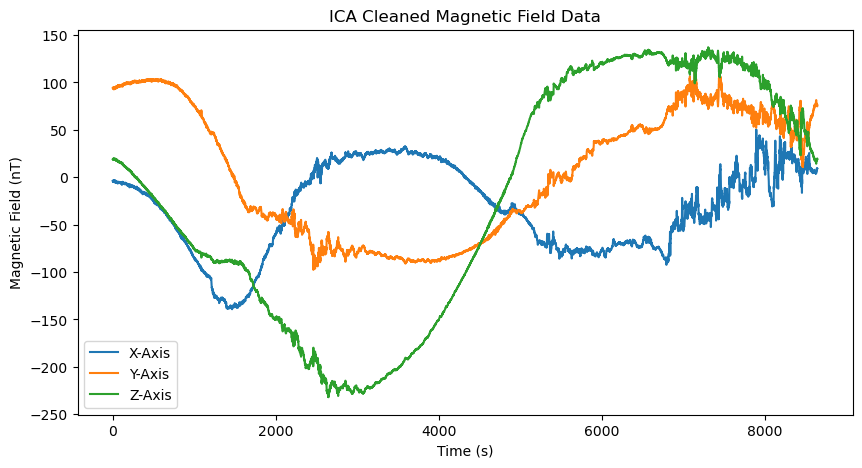

In [3]:
"Set Detrend to True and Uniform Filter Size used to remove the DC component"
ICA.detrend = True
ICA.uf = 400

"Clean the data"
B_ica = ICA.clean(np.copy(B))

"Plot the data"
plt.figure(figsize=(10, 5))
plt.title("ICA Cleaned Magnetic Field Data")
plt.plot(B_ica[0], label="X-Axis")
plt.plot(B_ica[1], label="Y-Axis")
plt.plot(B_ica[2], label="Z-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Magnetic Field (nT)")
plt.legend()
plt.show()


### Frequency-based Gradiometry (Ream et al. 2021)
The Ream et al. (2021) method functions by identifying intervals with interference, and then minimizes the frequencies associated with interference in the identified interval.

In order to identify noisy intervals, the difference between magnetometers is taken, and the rolling minimum and maximum values of the difference are identified. If the rolling min exceeds a certain threshold, set as REAM.delta_B, the interval is identified as noisy. The fft of the difference is taken and the frequencies with a magnitude above the REAM.p percentile are multiplied by a factor of 0.01. For an interval to be noisy, it must have a change above REAM.delta_B over REAM.n samples. This method is highly sensitive to the selection of parameters, and only works with infrequent noise sources.   

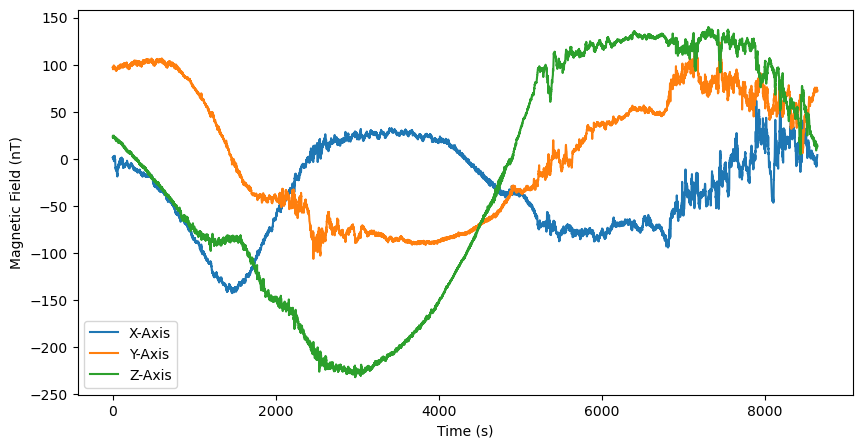

In [4]:
from magprime.algorithms import REAM

"Detrend the data"
REAM.detrend = True
REAM.uf = 360

"Algorithm Parameters"
REAM.delta_B = 5
REAM.n = 5
REAM.p = 98

"Clean the data"
B_ream = REAM.clean(np.copy(B))

"Plot the data"
plt.figure(figsize=(10, 5))
plt.plot(B_ream[0], label="X-Axis")
plt.plot(B_ream[1], label="Y-Axis")
plt.plot(B_ream[2], label="Z-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Magnetic Field (nT)")
plt.legend()

### SHEINKER
The Sheinker and Moldwin (2016) method assumes that the spacecraft interference is a single source with a gain of K between the outboard and inboard magnetometers, while the ambient magnetic field appears equally at each magnetometer. It uses the correlation between the signal difference and each magnetometer in order to identify the gain K.

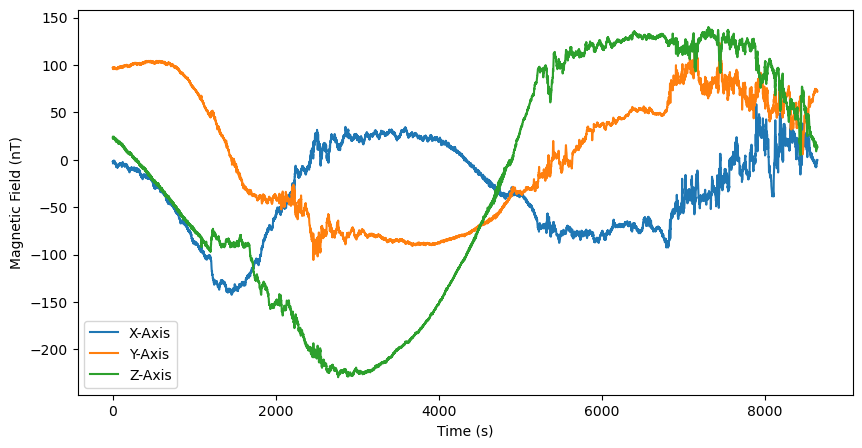

In [5]:
from magprime.algorithms import SHEINKER

"Detrend the data"
SHEINKER.uf = 400
SHEINKER.detrend = True

"Clean the data"
B_sheinker = SHEINKER.clean(np.copy(B))

"Plot the data"
plt.figure(figsize=(10, 5))
plt.plot(B_sheinker[0], label="X-Axis")
plt.plot(B_sheinker[1], label="Y-Axis")
plt.plot(B_sheinker[2], label="Z-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Magnetic Field (nT)")
plt.legend()


### Principal Component Gradiometry (PiCoG)
PiCoG functions by rotating the magnetometer measurements into a coordinate system that maximizes the variance of the interference in the new x-coordinate direction. The gain of the interference is identified in this direction and gradiometry is performed along this axis. This process can be repeated to remove interference from multiple sources.


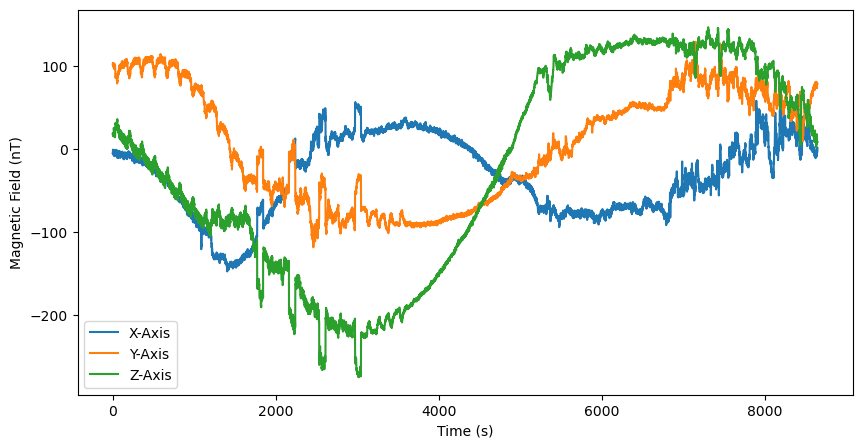

In [6]:
from magprime.algorithms import PiCoG

"Detrend the data"
PiCoG.uf = 800
PiCoG.detrend = True

"Clean the data"
B_picog = PiCoG.clean(np.copy(B))

"Plot the data"
plt.figure(figsize=(10, 5))
plt.plot(B_picog[0], label="X-Axis")
plt.plot(B_picog[1], label="Y-Axis")
plt.plot(B_picog[2], label="Z-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Magnetic Field (nT)")
plt.legend()



### WAIC-UP 
Wavelet-Adaptive Interference Cancellation for Underdetermined Platforms by Hoffmann and Moldwin (2023) extends the Sheinker and Moldwin (2016) algorithm to perform the same procedure in the wavelet domain. In this case, if the interference sources have different spectral content, multiple interference sources can be removed. 

In this algorithm, the parameter, dj, determines the scale resolution of the wavelet transform.

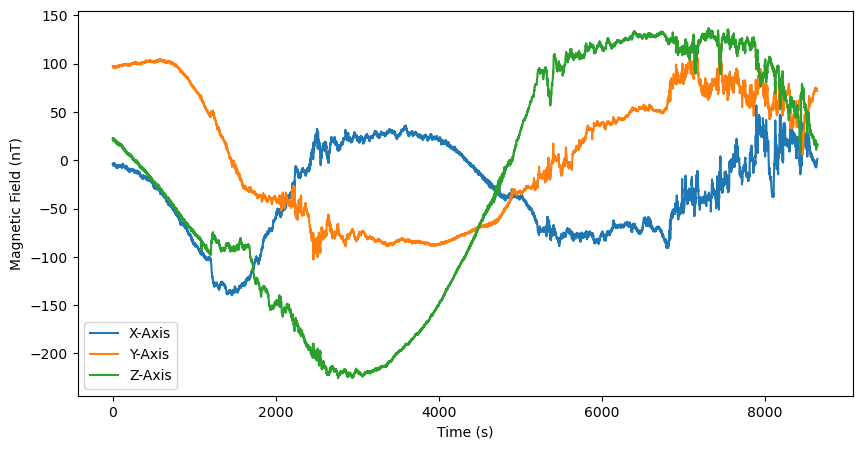

In [7]:
from magprime.algorithms import WAICUP

"Detrend the data"
WAICUP.uf = 800
WAICUP.detrend = True
WAICUP.lowest_freq = .5/86400

"Algorithm Parameters"
WAICUP.fs = .1
WAICUP.dj = 1/4

"Clean the data"
B_waicup = WAICUP.clean(np.copy(B))

"Plot the data"
plt.figure(figsize=(10, 5))
plt.plot(B_waicup[0], label="X-Axis")
plt.plot(B_waicup[1], label="Y-Axis")
plt.plot(B_waicup[2], label="Z-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Magnetic Field (nT)")
plt.legend()


### Multichannel Singular Spectrum Analysis (M-SSA)
M-SSA is an advanced method to break down signals into their statistically significant components. This method is used by Finley et al. (2023) to remove interference by correlating the separated signal components with the difference between the magnetometer measurements. Components that are identified as noise through this correlation are dropped when the signal is reconstructed. 

The parameter alpha is the threshold for interference identification. If a signal has a correlation above alpha, then it is excluded. The window_size parameter determines the largest period of interference that can be identified.

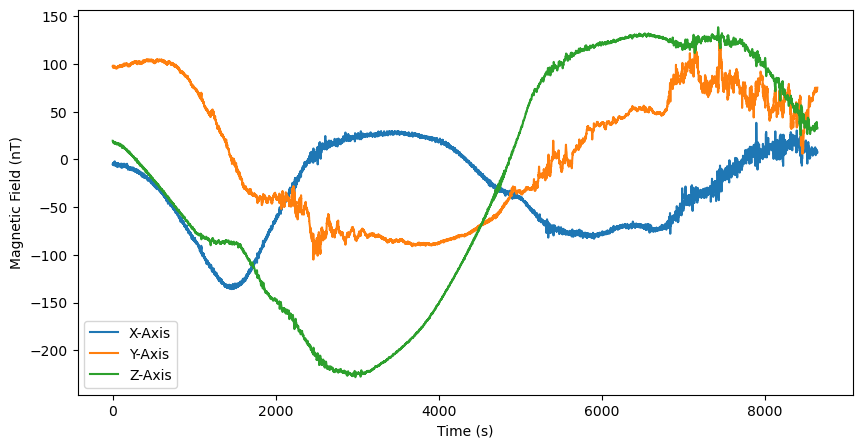

In [9]:
from magprime.algorithms import MSSA

"Detrend the data"
MSSA.uf = 360
MSSA.detrend = True

"Algorithm Parameters"
MSSA.window_size = 360
MSSA.alpha = 0.05


"Clean the data"
B_mssa = MSSA.clean(np.copy(B))

"Plot the data"
plt.figure(figsize=(10, 5))
plt.plot(B_mssa[0], label="X-Axis")
plt.plot(B_mssa[1], label="Y-Axis")
plt.plot(B_mssa[2], label="Z-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Magnetic Field (nT)")
plt.legend()

### Underdetermined Blind Source Separation (UBSS)
UBSS is a popular method in acoustics and radar signal processing that separates signals from multiple sources. It functions by identifying the gain of each signal at each magnetometer through cluster analysis to form a mixing matrix (sensing matrix). After forming the mixing matrix, the signals are separated using compressive sensing.

UBSS performs this operation in the time-frequency domain. In this algorithm, we use the NSGT transform to convert the time-series into time-frequency. The NSGT transform uses the bpo (bands per octave) parameter to control the frequency resolution. 

The parameter, sigma, is used in cluster analysis to filter out low magnetitude time-frequency bins, and is proportional to the random normal noise of the instrument. 

[[ 1.  +0.j    0.87+0.j    0.98+0.j  ]
 [ 1.  +0.j   -0.49-0.02j  0.18+0.07j]]


100%|██████████| 9208/9208 [00:23<00:00, 395.91it/s]


[[ 1.  +0.j    0.9 +0.j    0.91+0.j  ]
 [ 1.  +0.j   -0.43+0.04j  0.39+0.06j]]


100%|██████████| 9208/9208 [00:26<00:00, 353.02it/s]


[[ 1.  +0.j    0.97+0.j    0.11+0.j    0.06+0.j    0.07+0.j    0.22+0.j
   0.12+0.j    0.13+0.j  ]
 [ 1.  +0.j   -0.25-0.01j  0.32-0.94j -0.09+0.99j -0.58+0.81j -0.94+0.25j
  -0.91-0.41j  0.68+0.73j]]


100%|██████████| 9208/9208 [00:23<00:00, 392.47it/s]


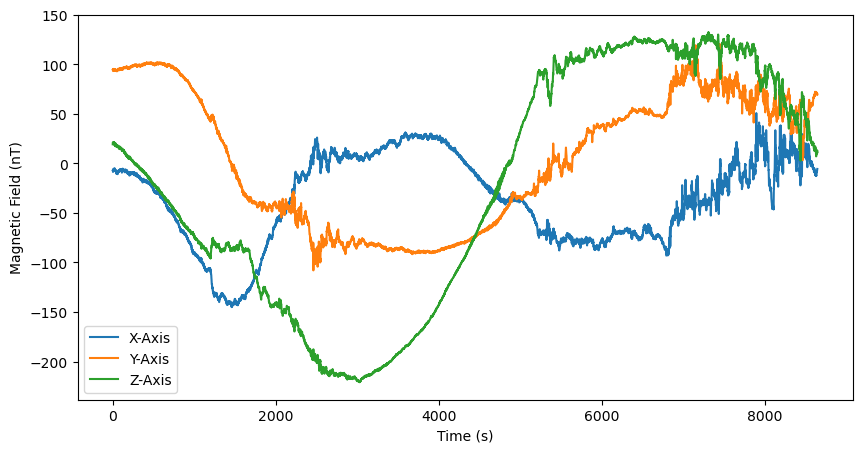

In [8]:
from magprime.algorithms import UBSS

"Detrend the data"
UBSS.detrend = False

"Algorithm Parameters"
UBSS.sigma = 10
UBSS.fs = .1
UBSS.cs_iters = 2
UBSS.bpo = 5

"Clean the data"
B_ubss = UBSS.clean(np.copy(B), triaxial=True)

"Plot the data"
plt.figure(figsize=(10, 5))
plt.plot(B_ubss[0], label="X-Axis")
plt.plot(B_ubss[1], label="Y-Axis")
plt.plot(B_ubss[2], label="Z-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Magnetic Field (nT)")
plt.legend()



### Ness Gradiometry
Ness (1971) gradiometry is the first spacecraft magnetometer interference algorithm. It assumes that the spacecraft magnetic field is a single dipole and can be removed through solving a linear system of equations where the interference has a gain of K determined by the shape of the dipole field. This method was extended by Neubauer and typically requires the exact magnetometer locations relative to the spacecraft.

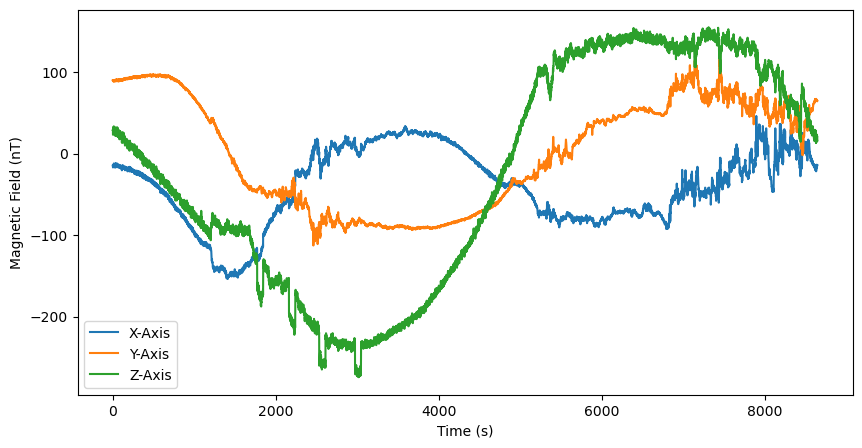

In [10]:
from magprime.algorithms import NESS
from magprime.utility import calculate_coupling_coefficients


"Algorithm Parameters"
NESS.aii = calculate_coupling_coefficients(B, fs = 0.1, sspTol=20)

"Clean the data"
B_ness = NESS.clean(np.copy(B))

"Plot the data"
plt.figure(figsize=(10, 5))
plt.plot(B_ness[0], label="X-Axis")
plt.plot(B_ness[1], label="Y-Axis")
plt.plot(B_ness[2], label="Z-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Magnetic Field (nT)")
plt.legend()

